# Step 4: Make Predictions on Real Data

Install missing libraries

In [1]:
!pip install blimpy
!pip install keras
!pip install scikit-plot
!pip install opencv-python-headless

Import relevant libraries

In [2]:
import os
from keras import applications
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import google.datalab.storage as storage #To access cloud storage buckets
import random
warnings.filterwarnings('ignore')
import pylab as plt
import numpy as np
import PIL
import os
from scipy import ndimage, misc
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from blimpy import Filterbank
from blimpy import Waterfall
from blimpy.utils import db, lin, rebin, closest
import cv2

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load the model created in step 3

In [13]:
model = load_model('seti_bespoke_20190628_RH_v01.h5')

Some useful functions

In [191]:
def get_slice(file_location, f_range, f_start):

  f_stop = f_start + f_range
  t_start = 0 
  t_stop = 16
  MAX_IMSHOW_POINTS = (8192, 4096)

  filterbank = Waterfall(file_location, f_start=f_start, f_stop=f_stop,t_start=t_start,t_stop=t_stop)

  plot_f, data_temp = filterbank.grab_data()

  if filterbank.header[b'foff'] < 0:
          data_temp = data_temp[..., ::-1] # Reverse data
          plot_f = plot_f[::-1]

  dec_fac_x, dec_fac_y = 1, 1

  if data_temp.shape[0] > MAX_IMSHOW_POINTS[0]:
      dec_fac_x = int(data_temp.shape[0] / MAX_IMSHOW_POINTS[0])

  if data_temp.shape[1] > MAX_IMSHOW_POINTS[1]:
      dec_fac_y =  int(data_temp.shape[1] /  MAX_IMSHOW_POINTS[1])

  data_temp = rebin(data_temp, dec_fac_x, dec_fac_y)

  extent = filterbank._calc_extent(plot_f=plot_f,plot_t=filterbank.timestamps)

  #A1_avg = np.mean(data_temp)
  #A1_max = data_temp.max()
  #A1_std = np.std(data_temp)

  return(data_temp, extent)

# predicting images

window = 0.001

def save_and_predict(filename, fstart):

    data_slice, extent = get_slice(filename, f_range=window, f_start=fstart)
    
    plt.rcParams["axes.grid"] = False

    plt.imshow(data_slice,
               aspect='auto',
               origin='lower',
               rasterized=True,
               interpolation='none',
               extent=extent,
               cmap='viridis')
    
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
    plt.imsave('test.png', data_slice, cmap='viridis')

    plt.close()
    
    img_dim  = 197

    img = image.load_img('test.png', target_size=(img_dim, img_dim))
    x = image.img_to_array(img)
    x = x/255.0
    
    x = cv2.GaussianBlur(x, (3, 3), 1)
        
    plt.rcParams["axes.grid"] = False

    plt.imshow(x,
               aspect='auto',
               origin='lower',
               rasterized=True,
               interpolation='none',
               extent=extent,
               cmap='viridis')
    plt.colorbar(cmap='viridis')

    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
   
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)
    class_predicted = model.predict_classes(x)
    
    if classes[0].argmax() == 0:
        sig_type = 'noise'
    if classes[0].argmax() == 1:
        sig_type = 'line'
    if classes[0].argmax() == 2:
        sig_type = 'wibble'
    if classes[0].argmax() == 3:
        sig_type = 'chopped_line'
    if classes[0].argmax() == 4:
        sig_type = 'curve'
    if classes[0].argmax() == 5:
        sig_type = 'brightpixel'
        
    return(sig_type, classes, class_predicted)

Make Predictions on the Breakthrough 692 data (small files from https://seti.berkeley.edu/lband2017/landing.html)

### HIP4436

[[0.15215257 0.41290423 0.14290802 0.07581447 0.21622074]]
I think this is:  line


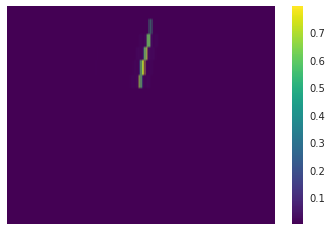

In [192]:
file = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_80733_HIP4436_0032.gpuspec.0000.h5'
file2 = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_81079_HIP3333_0033.gpuspec.0000.h5'
file3 = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_81424_HIP4436_0034.gpuspec.0000.h5'
file4 = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_81768_HIP3597_0035.gpuspec.0000.h5'
file5 = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_82111_HIP4436_0036.gpuspec.0000.h5'
file6 = 'filterbank/HIP4436/spliced_blc0001020304050607_guppi_57803_82459_HIP3677_0037.gpuspec.0000.h5'

filenames_list_4436 = [file,file2,file3,file4,file5,file6]

img_dim  = 197
sig_type, classes, class_predicted = save_and_predict(filenames_list_4436[2], 2251.264842)

print(classes)
print('I think this is:  ' + sig_type)

Text(0.5,1,u'Signal Type')

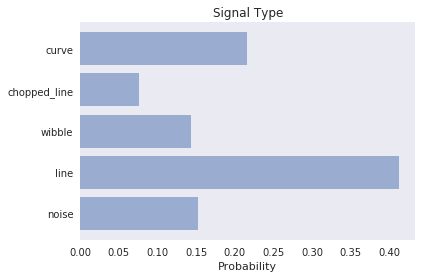

In [193]:
objects = ('noise', 'line', 'wibble', 'chopped_line', 'curve')
y_pos = np.arange(len(objects))

plt.barh(y_pos, classes[0].tolist(), align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Signal Type')

### HIP65352

blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
[[0.00173515 0.24928403 0.70616925 0.0230336  0.019778  ]]
I think this is:  wibble


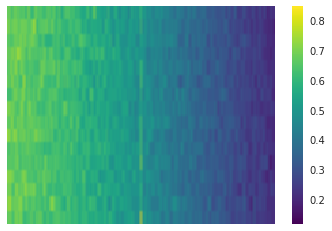

In [196]:
file = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_34297_HIP65352_0027.gpuspec.0000.h5'
file2 = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_34623_HIP65352_OFF_0028.gpuspec.0000.h5'
file3 = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_34949_HIP65352_0029.gpuspec.0000.h5'
file4 = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_35275_HIP65352_OFF_0030.gpuspec.0000.h5'
file5 = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_35601_HIP65352_0031.gpuspec.0000.h5'
file6 = 'filterbank/HIP65352/spliced_blc02030405_2bit_guppi_57459_35601_HIP65352_0031.gpuspec.0000.h5' #not really

filenames_list_65352 = [file,file2,file3,file4,file5,file6]

img_dim  = 197

sig_type, classes, class_predicted = save_and_predict(filenames_list_65352[1], 0)
print(classes)
print('I think this is:  ' + sig_type)

Text(0.5,1,u'Signal Type')

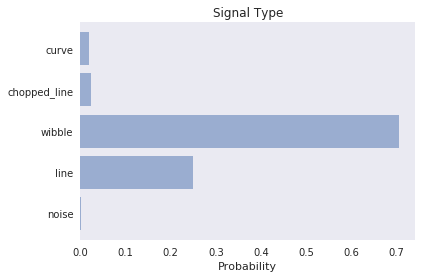

In [197]:
objects = ('noise', 'line', 'wibble', 'chopped_line', 'curve')
y_pos = np.arange(len(objects))

plt.barh(y_pos, classes[0].tolist(), align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Signal Type')

### HIP20901

[[0.04833651 0.29783753 0.33924356 0.11438382 0.20019855]]
I think this is:  wibble


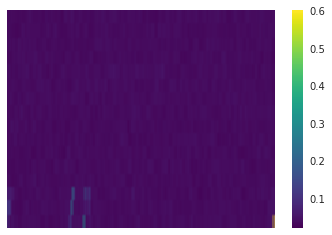

In [198]:
file = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_50058_Hip20901_0027.gpuspec.0000.h5'
file2 = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_50409_Hip19822_0028.gpuspec.0000.h5'
file3 = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_50760_Hip20901_0029.gpuspec.0000.h5'
file4 = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_51107_Hip19834_0030.gpuspec.0000.h5'
file5 = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_51453_Hip20901_0031.gpuspec.0000.h5'
file6 = 'filterbank/HIP20901/spliced_blc0001020304050607_guppi_57606_51802_Hip19862_0032.gpuspec.0000.h5'

filenames_list_20901 = [file,file2,file3,file4,file5,file6]

img_dim  = 197

sig_type, classes, class_predicted = save_and_predict(filenames_list_20901[0], 2251.264842)
print(classes)
print('I think this is:  ' + sig_type)

Text(0.5,1,u'Signal Type')

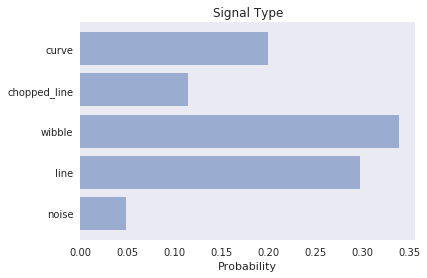

In [199]:
objects = ('noise', 'line', 'wibble', 'chopped_line', 'curve')
y_pos = np.arange(len(objects))

plt.barh(y_pos, classes[0].tolist(), align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Signal Type')

Bulk Predictions (Breakthrough 692)

In [200]:
def predict_x6(file_list, fstart):
  sig_type1, classes1, class_predicted1 = save_and_predict(file_list[0], fstart)
  sig_type2, classes2, class_predicted2 = save_and_predict(file_list[1], fstart)
  sig_type3, classes3, class_predicted3 = save_and_predict(file_list[2], fstart)
  sig_type4, classes4, class_predicted4 = save_and_predict(file_list[3], fstart)
  sig_type5, classes5, class_predicted5 = save_and_predict(file_list[4], fstart)
  sig_type6, classes6, class_predicted6 = save_and_predict(file_list[5], fstart)
  
  return[sig_type1,sig_type2,sig_type3,sig_type4,sig_type5,sig_type6]

['line', 'noise', 'line', 'noise', 'line', 'noise']

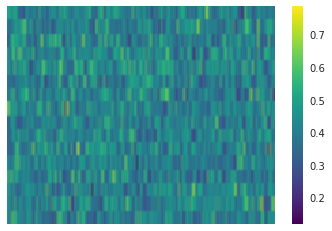

In [201]:
results_x6_4436 = predict_x6(filenames_list_4436, 2251.264842)
results_x6_4436

blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.
blimpy.file_wrapper WARNING  Setting f_stop = 1876.464842, since f_stop not given or not valid.


['line', 'wibble', 'line', 'wibble', 'wibble', 'wibble']

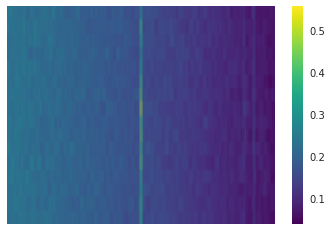

In [202]:
results_x6_65352 = predict_x6(filenames_list_65352, 0)
results_x6_65352

['wibble', 'noise', 'wibble', 'noise', 'wibble', 'noise']

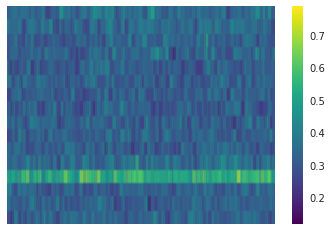

In [203]:
results_x6_20901 = predict_x6(filenames_list_20901, 2251.264842)
results_x6_20901

Raw Filterbanks: from Pre-prepared images in Step 1

In [75]:
def predict_from_image_file(image_file):

  img_dim  = 197

  img = image.load_img(image_file, target_size=(img_dim, img_dim))
  x = image.img_to_array(img)
  x = x/255.0

  x = cv2.GaussianBlur(x, (3, 3), 1)
  x = np.expand_dims(x, axis=0)

  classes = model.predict(x)
  class_predicted = model.predict_classes(x)

  if classes[0].argmax() == 0:
      sig_type = 'noise'
  if classes[0].argmax() == 1:
      sig_type = 'line'
  if classes[0].argmax() == 2:
      sig_type = 'wibble'
  if classes[0].argmax() == 3:
      sig_type = 'chopped_line'
  if classes[0].argmax() == 4:
      sig_type = 'curve'
  if classes[0].argmax() == 5:
      sig_type = 'brightpixel'

  return(sig_type)

In [19]:
def predict_x6_image_files(iteration):
  sig_type1 = predict_from_image_file('A1/A1_' + str(iteration) + '.png')
  sig_type2 = predict_from_image_file('B/B_' + str(iteration) + '.png')
  sig_type3 = predict_from_image_file('A2/A2_' + str(iteration) + '.png')
  sig_type4 = predict_from_image_file('C/C_' + str(iteration) + '.png')
  sig_type5 = predict_from_image_file('A3/A3_' + str(iteration) + '.png')
  sig_type6 = predict_from_image_file('D/D_' + str(iteration) + '.png')
  
  return[sig_type1,sig_type2,sig_type3,sig_type4,sig_type5,sig_type6,iteration]

Alien Detector!

In [12]:
def alien_detector(results_x6):
  points = 0
  #A SIGNAL
  if results_x6[0] != 'noise':
    points = points + 10
  #B SIGNAL
  if results_x6[1] == 'noise':
    points = points + 5
  if results_x6[1] == results_x6[0]:
    points = points - 10
  if results_x6[1] != 'noise' and results_x6[1] != results_x6[0]:
    points = points + 4
  #A2 SIGNAL
  if results_x6[2] == 'noise':
    points = points + 0
  if results_x6[2] == results_x6[0]:
    points = points + 10
  if results_x6[2] != 'noise' and results_x6[2] != results_x6[0]:
    points = points + 2
  #C SIGNAL
  if results_x6[3] == 'noise':
    points = points + 5
  if results_x6[3] == results_x6[0]:
    points = points - 10
  if results_x6[3] != 'noise' and results_x6[3] != results_x6[0]:
    points = points + 2
  #A3 SIGNAL
  if results_x6[4] == 'noise':
    points = points + 0
  if results_x6[4] == results_x6[0]:
    points = points + 10
  if results_x6[4] != 'noise' and results_x6[4] != results_x6[0]:
    points = points + 2
  #D SIGNAL
  if results_x6[5] == 'noise':
    points = points + 5
  if results_x6[5] == results_x6[0]:
    points = points - 10
  if results_x6[5] != 'noise' and results_x6[5] != results_x6[0]:
    points = points + 4
    
  if results_x6[0] == 'noise' and results_x6[1] == 'noise' and results_x6[2] == 'noise' and results_x6[3] == 'noise' and results_x6[4] == 'noise' and results_x6[5] == 'noise':
    points = 0

  if points == 45:
      print('Aliens!')
  if points > 0 and points < 45:
      print('Maybe?')
  if points <= 0:
      print('Nothing going on here')
    
  return(points)

Make the predictions

In [38]:
import timeit
start_time = timeit.default_timer()

start_f = 1797.94921875 #get from code that converts to png. Send across with images
window = 0.002
num_files = 2999

import csv

with open('seti_timed.csv', 'a') as csvFile:
  writer = csv.writer(csvFile)

  for i in range(1,num_files):
    results_from_image_files = predict_x6_image_files(i)
    iteration = results_from_image_files[6]
    results_from_image_files = results_from_image_files[0:6]
    #print(results_from_image_files)
    result = alien_detector(results_from_image_files)
    result_list = [start_f, iteration, result]
    writer.writerow(result_list)
    start_f = start_f + window
   
csvFile.close()

elapsed = timeit.default_timer() - start_time
elapsed

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Not

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing go

Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on h

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing go

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Not

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing goi

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Not

Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Maybe?
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing going on here
Nothing goi

187.9197199344635

In [42]:
!gsutil cp seti.csv gs://seti_model_backup #copy csv results to bucket



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://seti.csv [Content-Type=text/csv]...
/ [1 files][ 77.4 KiB/ 77.4 KiB]                                                
Operation completed over 1 objects/77.4 KiB.                                     


Timings

In [41]:
print('To process ' + str(num_files) + ' frequencies, or ' + str(num_files*6) + ' files, took ' + str(elapsed) + ' seconds')
print('An entire filterbank collection requires 3M files to be processed. That would take ' + str(((3e6/(num_files*6)) * elapsed)/3600) + ' hours')

To process 2999 frequencies, or 17994 files, took 187.919719934 seconds
An entire filterbank collection requires 3M files to be processed. That would take 8.70288799667 hours


Force a fake result from real data, to check the alien detector

In [77]:
#Force fake result...

iteration_of_interest = 83

def predict_x6_image_files_fake(iteration):
  sig_type1 = predict_from_image_file('A1/A1_' + str(iteration) + '.png')
  sig_type2 = predict_from_image_file('B/B_' + str(iteration) + '.png')
  sig_type3 = predict_from_image_file('A1/A1_' + str(iteration) + '.png')
  sig_type4 = predict_from_image_file('C/C_' + str(iteration) + '.png')
  sig_type5 = predict_from_image_file('A1/A1_' + str(iteration) + '.png')
  sig_type6 = predict_from_image_file('D/D_' + str(iteration) + '.png')
  
  return[sig_type1,sig_type2,sig_type3,sig_type4,sig_type5,sig_type6,iteration]

fake_result = predict_x6_image_files_fake(iteration_of_interest)[0:6]
print(fake_result)
alien_detector(fake_result)

['chopped_line', 'noise', 'chopped_line', 'noise', 'chopped_line', 'noise']
Aliens!


45